<a href="https://colab.research.google.com/github/SahputraS/Outbreak-Simulation-and-Detection-Testing/blob/main/Manual_Evaluation_SP_MG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import brier_score_loss

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import the Cases of SP and MG states

In [3]:
cases_sp = pd.read_csv('/content/drive/MyDrive/GISAID/cases_SP.csv')
cases_sp.head(3)

,Date,1V_A,1V_D.1.1,1V_E,1V_E.1,1V_F,2III_C.1.1,2II_F.1.1.2,3III_B.3.2,4II_B.1.3,endemic,outbreak
0,2022-01-02,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,7.593580,130.488813
1,2022-01-09,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,7.327945,90.147368
2,2022-01-16,0.0,0.0,0.0,88.680034,0.0,0.0,0.0,0.0,0.0,7.567792,88.680034


In [4]:
cases_mg = pd.read_csv('/content/drive/MyDrive/GISAID/cases_MG.csv')
cases_mg.head(3)

,Date,1V_A,1V_D.1.1,1V_E,1V_E.1,1V_F,2II_F.1.1.2,3III_B.3.2,4II_B.1.3,endemic
0,2022-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.605632
1,2022-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.525571
2,2022-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.887560


In [5]:
# # Take the dates that exists on both states
# cases_sp["Date"] = pd.to_datetime(cases_sp["Date"]).dt.date
# cases_mg["Date"] = pd.to_datetime(cases_mg["Date"]).dt.date

# common_dates = np.intersect1d(cases_sp["Date"].unique(), cases_mg["Date"].unique())

# cases_sp2 = cases_sp[cases_sp["Date"].isin(common_dates)].copy().reset_index(drop=True)
# cases_mg2 = cases_mg[cases_mg["Date"].isin(common_dates)].copy().reset_index(drop=True)

In [6]:
cases_sp2 = cases_sp.copy()
cases_sp2['Date'] = pd.to_datetime(cases_sp2['Date']).dt.date
cases_mg2 = cases_mg.copy()
cases_mg2['Date'] = pd.to_datetime(cases_mg2['Date']).dt.date

For Cases:

Calculate the $P(d|x)$

In layman terms, the percentage of finding clade type 1VA/1V_D.1.1/.../endemic in each time step.


In [ ]:
def make_percent(cases_numw):
  dates = cases_numw['Date']
  num = cases_numw.drop(columns=['Date'])
  num = num.div(num.sum(axis=1), axis=0)

  cases_perc = num.copy()
  cases_perc['date'] = dates
  cases_perc['non_case'] = 0
  return cases_perc

In [ ]:
def filter_clades(cases_perc, target_clades):

  # all the "other" clades = all clades except the big 3
  other_cols = [c for c in cases_perc.columns if c not in target_clades + ['endemic', 'non_case', 'date']]

  # aggregate the other clades
  cases_perc['other'] = cases_perc[other_cols].sum(axis=1)
  cases_perc = cases_perc[target_clades + ['other', 'endemic', 'non_case', 'date']]
  return cases_perc

In [ ]:
# Make to percentage
cases_perc_sp = make_percent(cases_sp2)
cases_perc_mg = make_percent(cases_mg2)

# Focus on some clades classes (top 3) and turn into percent proportions
cc = ['1V_E.1', '2II_F.1.1.2', '3III_B.3.2']
cases_perc_sp = filter_clades(cases_perc_sp, cc)
cases_perc_mg = filter_clades(cases_perc_mg, cc)

In [ ]:
cases_perc_sp['states'] = 'SP'
cases_perc_mg['states'] = 'MG'

# A bit run-around by combining the states here
p_dx = pd.concat([cases_perc_sp, cases_perc_mg], axis=0)
p_dx.head()

,1V_E.1,2II_F.1.1.2,3III_B.3.2,other,endemic,non_case,date,states
0,0.430819,0.00000,0.0,0.430819,0.138362,0,2022-01-16,SP
1,0.448211,0.00000,0.0,0.448211,0.103578,0,2022-01-23,SP
2,0.340439,0.11348,0.0,0.453919,0.092162,0,2022-01-30,SP
3,0.406976,0.04522,0.0,0.452196,0.095608,0,2022-02-06,SP
4,0.461732,0.00000,0.0,0.461732,0.076537,0,2022-02-13,SP


## Import the Signals of SP and MG States

In [ ]:
signal_sp = pd.read_csv('/content/drive/MyDrive/GISAID/MEM_classification_SP.csv')
signal_sp.rename(columns={"data_iniSE": "date"}, inplace=True)
signal_sp['date'] = pd.to_datetime(signal_sp['date']).dt.date

valid_dates1 = cases_sp2['Date'].unique()
signal_sp = signal_sp[signal_sp['date'].isin(valid_dates1)].copy().reset_index(drop=True)

signal_sp = signal_sp[['date', 'nivel', 'ibge', 'rate_pop']]
signal_sp.head(5)

,date,nivel,ibge,rate_pop
0,2022-01-16,2,3500105,19.936772
1,2022-01-23,2,3500105,8.544331
2,2022-01-30,2,3500105,19.936772
3,2022-02-06,2,3500105,14.240551
4,2022-02-13,2,3500105,11.392441


In [ ]:
signal_sp[signal_sp['rate_pop']==0]

,date,nivel,ibge,rate_pop,nivel2
151,2022-01-16,1,3500808,0.0,non_case
152,2022-01-23,1,3500808,0.0,non_case
154,2022-02-06,1,3500808,0.0,non_case
156,2022-02-20,1,3500808,0.0,non_case
157,2022-02-27,1,3500808,0.0,non_case
...,...,...,...,...,...
26870,2025-06-15,1,3557303,0.0,non_case
26872,2025-06-29,1,3557303,0.0,non_case
26873,2025-07-06,1,3557303,0.0,non_case
26875,2025-07-20,1,3557303,0.0,non_case


In [ ]:
signal_mg = pd.read_csv('/content/drive/MyDrive/GISAID/MEM_classification_MG.csv')
signal_mg.rename(columns={"data_iniSE": "date"}, inplace=True)
signal_mg['date'] = pd.to_datetime(signal_mg['date']).dt.date

valid_dates2 = cases_mg2['Date'].unique()
signal_mg = signal_mg[signal_mg['date'].isin(valid_dates2)].copy().reset_index(drop=True)

signal_mg = signal_mg[['date', 'nivel', 'ibge', 'rate_pop']]
signal_mg.head(5)

,date,nivel,ibge,rate_pop
0,2022-02-27,1,3101508,2.824779
1,2022-04-10,2,3101508,2.824779
2,2022-04-17,2,3101508,2.824779
3,2022-04-24,2,3101508,2.824779
4,2022-05-01,2,3101508,8.474337


## Import FF and ARIMA Signal for MG and SP

In [ ]:
signal_dsp= pd.read_csv('/content/drive/MyDrive/Mosquito_Data/dengue_spaulo_all.csv')
signal_dsp['Week'] = pd.to_datetime(signal_dsp['Week']).dt.date
signal_dsp.rename(columns={"Week": "date"}, inplace=True)
signal_dsp = signal_dsp[signal_dsp['date'].isin(cases_sp2['Date'].unique())].copy().reset_index(drop=True)

signal_dsp.head(5)

,date,Reported_Cases,Farrington_Flexible,ARIMA,Farrington_Flexible_pval,ARIMA_pval
0,2022-01-16,7313.569353,0,1,0.600541,0.014189
1,2022-01-23,7996.680551,0,0,0.653764,0.365024
2,2022-01-30,8638.988440,0,0,0.690267,0.677689
3,2022-02-06,9376.965023,0,0,0.715265,0.455251
4,2022-02-13,10543.559735,0,0,0.702033,0.237863


In [ ]:
signal_dmg= pd.read_csv('/content/drive/MyDrive/Mosquito_Data/dengue_mg_all.csv')
signal_dmg['Week'] = pd.to_datetime(signal_dmg['Week']).dt.date
signal_dmg.rename(columns={"Week": "date"}, inplace=True)
signal_dmg = signal_dmg[signal_dmg['date'].isin(cases_mg2['Date'].unique())].copy().reset_index(drop=True)

signal_dmg.head(5)

,date,Reported_Cases,Farrington_Flexible,ARIMA,Farrington_Flexible_pval,ARIMA_pval
0,2022-02-27,1557.359115,0,1,0.673635,5.499420e-03
1,2022-04-10,5634.338568,1,1,0.008454,2.116195e-05
2,2022-04-17,6072.284679,1,1,0.004080,2.220446e-16
3,2022-04-24,6887.864296,1,1,0.000913,0.000000e+00
4,2022-05-01,6923.893729,1,1,0.000388,4.168377e-07


For Signals (part 1):

First compute $w(s,x)$, the weight of signal $s$ in cell $x$.
In general, $w(s,x)$ can be any measure of signal strength (e.g. a significance value, p-value, or other weight).
In this case, $x$ is a state-month, and $w(s,x)$ is defined as the percentage of occurrences of signal $s$ among all signal labels (outbreak, endemic, non_case) across all municipality-week cells within that state and month.

One then compute $p(s|x)$, the probability of observing signal $s$ in cell $x$, as $p(s|x) = \frac{w(s,x)}{\sum_{s'} w(s',x)}$
Because the $w(s,x)$ values are already normalized to sum to $1$ over all signals, in this specific case one has simply $p(s|x) = w(s,x)$


In [ ]:
def make_percent_signal(signal_df):

    signal_df['nivel2'] = signal_df['nivel'].astype('object')

    m1 = (signal_df['nivel'] == 1) & (signal_df['rate_pop'] == 0)   # green & zero cases
    m2 = (signal_df['nivel'] == 1) & (signal_df['rate_pop']  > 0)   # green & some cases

    signal_df.loc[m1, 'nivel2'] = 'non_case'
    signal_df.loc[m2, 'nivel2'] = 'endemic'

    nivel_c = (signal_df.groupby(['date', 'nivel2'], as_index=False)
                         .size()
                         .rename(columns={'size': 'n_rows'}))

    nivel_cw = (nivel_c
                .pivot(index='date', columns='nivel2', values='n_rows')
                .fillna(0)
                .astype(int))

    # Combine 2, 3, 4 into 'alarm'
    nivel_cw['alarm'] = nivel_cw[2] + nivel_cw[3] + nivel_cw[4]
    nivel_cw.drop(columns=[2, 3, 4], inplace=True)

    # flatten
    nivel_cw.columns.name = None
    nivel_cw = nivel_cw.reset_index()
    nivel_cw['date'] = pd.to_datetime(nivel_cw['date'])

    # convert to percentages
    cols = ['non_case', 'endemic', 'alarm']
    total = nivel_cw[cols].sum(axis=1)

    nivel_perc = nivel_cw.copy()
    nivel_perc[cols] = nivel_cw[cols].div(total, axis=0)

    return nivel_perc

In [ ]:
signal_sp2 = make_percent_signal(signal_sp)
signal_mg2 = make_percent_signal(signal_mg)

signal_sp2['states'] = 'SP'
signal_mg2['states'] = 'MG'

signal_perc = pd.concat([signal_sp2, signal_mg2], axis=0)

signal_perc['date'] = pd.to_datetime(signal_perc['date'])
signal_perc

,date,endemic,non_case,alarm,states
0,2022-01-16,0.331461,0.224719,0.443820,SP
1,2022-01-23,0.376404,0.219101,0.404494,SP
2,2022-01-30,0.331461,0.219101,0.449438,SP
3,2022-02-06,0.443820,0.174157,0.382022,SP
4,2022-02-13,0.466292,0.162921,0.370787,SP
...,...,...,...,...,...
60,2025-05-04,0.506494,0.000000,0.493506,MG
61,2025-05-11,0.467532,0.012987,0.519481,MG
62,2025-05-18,0.571429,0.038961,0.389610,MG
63,2025-05-25,0.675325,0.025974,0.298701,MG


Get the weight and the $p(s|x)$ for the FF and SARIMA method

In [ ]:
def p_table_from_pvals(df, pval_col, state_code):

    # weights
    w_alarm = 1.0 - df[pval_col]
    w_end   = df[pval_col]
    w_nc    = 0.0  # this algorithm cannot emit non_case -> weight 0

    denom = w_alarm + w_end + w_nc  # = 1 here, but keep it explicit

    endemic   = w_end   / denom
    non_case  = w_nc    / denom
    alarm     = w_alarm / denom

    out = pd.DataFrame({
        "date":   df["date"].values,
        "endemic": endemic.values,
        "non_case": non_case if isinstance(non_case, pd.Series) else non_case,
        "alarm":  alarm.values,
        "states": state_code
    })

    return out


In [ ]:
# Farrington
sp_ff = p_table_from_pvals(signal_dsp, "Farrington_Flexible_pval", "SP")
mg_ff = p_table_from_pvals(signal_dmg, "Farrington_Flexible_pval", "MG")

# ARIMA
sp_arima = p_table_from_pvals(signal_dsp, "ARIMA_pval", "SP")
mg_arima = p_table_from_pvals(signal_dmg, "ARIMA_pval", "MG")

ff_all = pd.concat([sp_ff, mg_ff], ignore_index=True)
arima_all = pd.concat([sp_arima, mg_arima], ignore_index=True)

For Signals (part 2):

Define the $p(d|s)$ or in layman terms "If the algorithm gives signal $s$, how can one associate it with cases label $d$?"

The certain rules are as follows:

1. For non_case

$p(d = non-case | s = non-case) = 1$,

$p(d \neq non-case | s = non-case) = 0$

2. For endemic

$p(d = endemic | s = endemic) = 1$,

$p(d \neq endemic | s = endemic) = 0$

3. For outbreak with endemic and non-case

$p(d = non-case | s = outbreak) = 0$,

$p(d = endemic | s = outbreak) = 0$



Assuming uniform probability, i.e. where if one see a signal it has uniform probability being associated with any clade labels.

$p(d = clade-k | s = outbreak) = 1/K$,

where K is number of clades


In [ ]:
# pds_co = 1/len(clade_counts)
pds_co = 1/4
pds_co

0.25

For Signals (part 3):

Compute $\hat{p}(d|x) = \sum_s{p(d|s)p(s|x)}$

Because I have only 1 outbreak, therefore it is simplified to
$\hat{p}(d = clade_k | x) = \frac{1}{K}p(s = outbreak | x)$

In [ ]:
clades_class = cc + ['other']
clades_class

['1V_E.1', '2II_F.1.1.2', '3III_B.3.2', 'other']

In [ ]:
def make_phat(phat_dx):
  new_cols = {
      clade: phat_dx['alarm'] * pds_co
      # for clade in clade_counts['clade']
      for clade in clades_class
  }

  phat_dx = phat_dx.assign(**new_cols)
  phat_dx = phat_dx.drop(columns=['alarm'])

  return phat_dx

In [ ]:
phat_id = make_phat(signal_perc)
phat_id.head(3)

,date,endemic,non_case,states,1V_E.1,2II_F.1.1.2,3III_B.3.2,other
0,2022-01-16,0.331461,0.224719,SP,0.110955,0.110955,0.110955,0.110955
1,2022-01-23,0.376404,0.219101,SP,0.101124,0.101124,0.101124,0.101124
2,2022-01-30,0.331461,0.219101,SP,0.112360,0.112360,0.112360,0.112360


In [ ]:
phat_ff = make_phat(ff_all)
phat_ff.head(3)

,date,endemic,non_case,states,1V_E.1,2II_F.1.1.2,3III_B.3.2,other
0,2022-01-16,0.600541,0.0,SP,0.099865,0.099865,0.099865,0.099865
1,2022-01-23,0.653764,0.0,SP,0.086559,0.086559,0.086559,0.086559
2,2022-01-30,0.690267,0.0,SP,0.077433,0.077433,0.077433,0.077433


In [ ]:
phat_arima = make_phat(arima_all)
phat_arima.head(3)

,date,endemic,non_case,states,1V_E.1,2II_F.1.1.2,3III_B.3.2,other
0,2022-01-16,0.014189,0.0,SP,0.246453,0.246453,0.246453,0.246453
1,2022-01-23,0.365024,0.0,SP,0.158744,0.158744,0.158744,0.158744
2,2022-01-30,0.677689,0.0,SP,0.080578,0.080578,0.080578,0.080578


## Scoring

In [ ]:
data_cols = cc + ['other', 'endemic', 'non_case']

In [ ]:
# make sure everything is lined up correctly
p_dx   = p_dx.sort_values(['states', 'date']).reset_index(drop=True)
phat_id = phat_id.sort_values(['states', 'date']).reset_index(drop=True)
phat_ff = phat_ff.sort_values(['states', 'date']).reset_index(drop=True)
phat_arima = phat_arima.sort_values(['states', 'date']).reset_index(drop=True)

# extra check that the dates are the same between the two dataframe
assert (p_dx['date'] == phat_id['date']).all()
assert (p_dx['date'] == phat_ff['date']).all()
assert (p_dx['date'] == phat_arima['date']).all()

In [ ]:
# Get the probability matrix
P = p_dx[data_cols].to_numpy()
Q_id = phat_id[data_cols].to_numpy()
Q_ff = phat_ff[data_cols].to_numpy()
Q_arima = phat_arima[data_cols].to_numpy()

Precision, Recall, F1

In [ ]:
cases_perc = p_dx[p_dx['states']=='MG']
clade_cols = data_cols.copy() #[c for c in cases_perc.columns if c not in ['date', 'states']]

cases_sorted = cases_perc.sort_values('date').reset_index(drop=True)
phat_sorted  = phat_id[phat_id['states'] == 'MG']
threshold = 0.2

results = []

for clade in clade_cols:

    p_true = cases_sorted[clade]
    p_hat  = phat_sorted[clade]

    # Turn into binary based on the threshold
    y_true = (p_true >= threshold).astype(int)
    y_pred = (p_hat  >= threshold).astype(int)

    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    results.append({
        'clade': clade,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })

clade_scores = pd.DataFrame(results)
clade_scores

,clade,precision,recall,f1
0,1V_E.1,0.516129,0.551724,0.533333
1,2II_F.1.1.2,0.419355,0.500000,0.456140
2,3III_B.3.2,0.161290,0.333333,0.217391
3,other,0.032258,0.333333,0.058824
4,endemic,0.142857,0.285714,0.190476
5,non_case,0.000000,0.000000,0.000000


**Cross Entropy**



In [ ]:
def cross_entropy_cells(P, Q, log_base=None):
    eps = 1e-12
    logs = np.log(Q + eps)
    if log_base is not None:
        logs = logs / np.log(log_base)   # e.g. base=2 for bits

    # H_x = - sum_d p(d|x) log q(d|x)
    H_per_cell = -np.sum(P * logs, axis=1)
    H_mean = H_per_cell.mean()

    return H_mean, H_per_cell

In [ ]:
H_mean, H_per_cell = cross_entropy_cells(P, Q_id, log_base=2)
print("Mean cross-entropy:", H_mean)

Mean cross-entropy: 3.561939991684608


In [ ]:
H_mean, H_per_cell = cross_entropy_cells(P, Q_ff, log_base=2)
print("Mean cross-entropy:", H_mean)

Mean cross-entropy: 3.132040720473419


In [ ]:
H_mean, H_per_cell = cross_entropy_cells(P, Q_arima, log_base=2)
print("Mean cross-entropy:", H_mean)

Mean cross-entropy: 10.809863031789334


In [ ]:
def calc_entropy(P,Q):
  # 1. Cross-entropy of your predictor: H(p, p_hat)
  H_pred_mean, H_pred_per_cell = cross_entropy_cells(P, Q, log_base=2)

  # 2. Entropy of the true distribution (perfect predictor): H(p) = H(p, p)
  H_true_mean, H_true_per_cell = cross_entropy_cells(P, P, log_base=2)

  # 3. Gap = average KL divergence per cell
  gap_mean = H_pred_mean - H_true_mean           # scalar
  KL_per_cell = H_pred_per_cell - H_true_per_cell  # vector, one per cell

  print("Entropy of truth H(p):", H_true_mean, "bits per cell")
  print("Cross-entropy H(p, p̂):", H_pred_mean, "bits per cell")
  print("Average KL divergence:", gap_mean, "bits per cell")


In [ ]:
calc_entropy(P, Q_id)

Entropy of truth H(p): 1.2501027953760218 bits per cell
Cross-entropy H(p, p̂): 3.561939991684608 bits per cell
Average KL divergence: 2.311837196308586 bits per cell


In [ ]:
calc_entropy(P, Q_ff)

Entropy of truth H(p): 1.2501027953760218 bits per cell
Cross-entropy H(p, p̂): 3.132040720473419 bits per cell
Average KL divergence: 1.8819379250973973 bits per cell


In [ ]:
calc_entropy(P, Q_arima)

Entropy of truth H(p): 1.2501027953760218 bits per cell
Cross-entropy H(p, p̂): 10.809863031789334 bits per cell
Average KL divergence: 9.559760236413313 bits per cell


**Mutual Information**

In [ ]:
signal_cols_orig = ['non_case', 'endemic', 'alarm']

def joint_and_mi(cases_df, signal_df, data_cols, log_base=None):
    # work on copies so we don't mutate originals
    cases  = cases_df.copy()
    signal = signal_df.copy()

    # make sure the join keys have the same dtype
    cases['date']  = pd.to_datetime(cases['date'])
    signal['date'] = pd.to_datetime(signal['date'])
    cases['states']  = cases['states'].astype(str)
    signal['states'] = signal['states'].astype(str)

    # rename signal columns so they don't clash with data 'endemic','non_case'
    signal = signal.rename(columns={
        'non_case': 'sig_non_case',
        'endemic':  'sig_endemic',
        'alarm':    'sig_alarm'
    })
    sig_cols = ['sig_non_case', 'sig_endemic', 'sig_alarm']

    # align cells
    df = (cases[['date', 'states'] + data_cols]
          .merge(signal[['date', 'states'] + sig_cols],
                 on=['date', 'states'], how='inner'))

    P = df[data_cols].to_numpy()   # (N, D)
    S = df[sig_cols].to_numpy()    # (N, S)
    N = P.shape[0]

    # p(d,s) = (1/N) sum_x p(d|x) p(s|x)
    joint = (P[:, :, None] * S[:, None, :]).sum(axis=0) / N   # (D, S)

    # marginals
    p_d = joint.sum(axis=1, keepdims=True)   # (D,1)
    p_s = joint.sum(axis=0, keepdims=True)   # (1,S)

    eps = 1e-12
    ratio = (joint + eps) / (p_d * p_s + eps)
    logs = np.log(ratio)
    if log_base is not None:
        logs = logs / np.log(log_base)       # e.g. log_base=2 → bits

    I = np.sum(joint * logs)  # mutual information

    # nice DataFrame for p(d,s)
    joint_df = pd.DataFrame(
        joint,
        index=data_cols,
        columns=['non_case', 'endemic', 'alarm']  # original signal names
    )

    return joint_df, p_d.ravel(), p_s.ravel(), I


Info Dengue

In [ ]:
joint_df, p_d, p_s, I = joint_and_mi(p_dx, signal_perc, data_cols, log_base=2)
print("Mutual information I(D;S) in bits:", I)
print("Joint p(d,s):")
print(joint_df)

Mutual information I(D;S) in bits: 0.030680237046441614
Joint p(d,s):
             non_case   endemic     alarm
1V_E.1       0.023325  0.102578  0.169869
2II_F.1.1.2  0.011938  0.063099  0.095820
3III_B.3.2   0.004565  0.019854  0.038217
other        0.027012  0.135301  0.159933
endemic      0.023726  0.082679  0.042084
non_case     0.000000  0.000000  0.000000


In [ ]:
# given clade, how often does it ring the alarm?
p_S_given_D = joint_df.div(joint_df.sum(axis=1), axis=0)
(p_S_given_D * 100).round(1)

,non_case,endemic,alarm
1V_E.1,7.9,34.7,57.4
2II_F.1.1.2,7.0,36.9,56.1
3III_B.3.2,7.3,31.7,61.0
other,8.4,42.0,49.6
endemic,16.0,55.7,28.3
non_case,NaN,NaN,NaN


In [ ]:
# given alarm, how often is it actually each clade/endemic?
p_D_given_S = joint_df.div(joint_df.sum(axis=0), axis=1)
(p_D_given_S * 100).round(1)

,non_case,endemic,alarm
1V_E.1,25.8,25.4,33.6
2II_F.1.1.2,13.2,15.6,18.9
3III_B.3.2,5.0,4.9,7.6
other,29.8,33.5,31.6
endemic,26.2,20.5,8.3
non_case,0.0,0.0,0.0


Farrington Flexible

In [ ]:
joint_ff, p_d_ff, p_s_ff, I_ff = joint_and_mi(p_dx, ff_all, data_cols, log_base=2)
print("Mutual information I(D;S) in bits:", I_ff)
print("Joint p(d,s):")
print(joint_ff)

Mutual information I(D;S) in bits: 0.044683853599393954
Joint p(d,s):
             non_case   endemic     alarm
1V_E.1            0.0  0.036449  0.259322
2II_F.1.1.2       0.0  0.057385  0.113473
3III_B.3.2        0.0  0.029117  0.033519
other             0.0  0.059559  0.262687
endemic           0.0  0.050962  0.097528
non_case          0.0  0.000000  0.000000


In [ ]:
# given clade, how often does it ring the alarm?
p_S_given_D_ff = joint_ff.div(joint_ff.sum(axis=1), axis=0)
(p_S_given_D_ff * 100).round(1)

,non_case,endemic,alarm
1V_E.1,0.0,12.3,87.7
2II_F.1.1.2,0.0,33.6,66.4
3III_B.3.2,0.0,46.5,53.5
other,0.0,18.5,81.5
endemic,0.0,34.3,65.7
non_case,NaN,NaN,NaN


In [ ]:
# given alarm, how often is it actually each clade/endemic?
p_D_given_S_ff = joint_ff.div(joint_ff.sum(axis=0), axis=1)
(p_D_given_S_ff * 100).round(1)

,non_case,endemic,alarm
1V_E.1,NaN,15.6,33.8
2II_F.1.1.2,NaN,24.6,14.8
3III_B.3.2,NaN,12.5,4.4
other,NaN,25.5,34.3
endemic,NaN,21.8,12.7
non_case,NaN,0.0,0.0


ARIMA

In [ ]:
joint_arima, p_d_arima, p_s_arima, I_arima = joint_and_mi(p_dx, arima_all, data_cols, log_base=2)
print("Mutual information I(D;S) in bits:", I_arima)
print("Joint p(d,s):")
print(joint_arima)

Mutual information I(D;S) in bits: 0.004781825681738608
Joint p(d,s):
             non_case   endemic     alarm
1V_E.1            0.0  0.126152  0.169619
2II_F.1.1.2       0.0  0.089033  0.081825
3III_B.3.2        0.0  0.028697  0.033938
other             0.0  0.129841  0.192405
endemic           0.0  0.065167  0.083323
non_case          0.0  0.000000  0.000000


In [ ]:
# given clade, how often does it ring the alarm?
p_S_given_D_arima = joint_arima.div(joint_arima.sum(axis=1), axis=0)
(p_S_given_D_arima * 100).round(1)

,non_case,endemic,alarm
1V_E.1,0.0,42.7,57.3
2II_F.1.1.2,0.0,52.1,47.9
3III_B.3.2,0.0,45.8,54.2
other,0.0,40.3,59.7
endemic,0.0,43.9,56.1
non_case,NaN,NaN,NaN


In [ ]:
# given alarm, how often is it actually each clade/endemic?
p_D_given_S_arima = joint_arima.div(joint_arima.sum(axis=0), axis=1)
(p_D_given_S_arima * 100).round(1)

,non_case,endemic,alarm
1V_E.1,NaN,28.7,30.2
2II_F.1.1.2,NaN,20.3,14.6
3III_B.3.2,NaN,6.5,6.0
other,NaN,29.6,34.3
endemic,NaN,14.8,14.8
non_case,NaN,0.0,0.0


# Precision, Recall, and More

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
def roc_f1_eval(p_dx, p_hat, cols):
    thr1_list = np.arange(0.05, 1.01, 0.05)
    thr2_grid = np.arange(0.05, 1.01, 0.05)  # fixed grid -> perfect for heatmaps

    rows = []
    roc_store = {}
    f1_store  = {}   # key thr1 -> {"thr2": grid, "f1": f1_values}

    for thr1 in thr1_list:
        Y_true  = (p_dx[cols].to_numpy() >= thr1).astype(int)
        Y_score = p_hat[cols].to_numpy()

        y_true  = Y_true.ravel()
        y_score = Y_score.ravel()

        if np.unique(y_true).size < 2:
            break

        auc = roc_auc_score(y_true, y_score)
        fpr, tpr, thr = roc_curve(y_true, y_score)

        thr1_key = round(float(thr1), 2)
        roc_store[thr1_key] = {"fpr": fpr, "tpr": tpr, "thr": thr}

        # F1 over a fixed threshold grid (fast + consistent across sims)
        f1s = np.array([f1_score(y_true, (y_score >= t).astype(int), zero_division=0)
                        for t in thr2_grid])

        f1_store[thr1_key] = {"thr2": thr2_grid, "f1": f1s}

        best_i = int(f1s.argmax())
        rows.append({
            "thr1": thr1_key,
            "auc_micro": float(auc),
            "best_thr2": float(thr2_grid[best_i]),
            "best_f1": float(f1s[best_i]),
            "pos_rate": float(y_true.mean()),
        })

    return pd.DataFrame(rows), roc_store, f1_store


In [ ]:
def f1_heatmap_from_stores(f1_store_list, band=(0.25, 0.75), title_prefix=""):

    # allow passing a single dict (one sim) OR a list of dicts (many sims)
    if isinstance(f1_store_list, dict):
        f1_store_list = [f1_store_list]

    thr1s = sorted(f1_store_list[0].keys())

    first = f1_store_list[0][thr1s[0]]
    thr2 = first.get("thr2", first.get("thr2_grid"))
    if thr2 is None:
        raise KeyError("Couldn't find thr2 grid. Expected key 'thr2' or 'thr2_grid'.")

    F = np.stack([[s[thr1]["f1"] for thr1 in thr1s] for s in f1_store_list], axis=0)

    med = np.median(F, axis=0)

    title = "F1"
    if title_prefix:
        title = f"{title_prefix} — {title}"

    plt.figure(figsize=(10, 6))
    plt.imshow(
        med , aspect="auto", origin="lower",
        extent=[float(np.min(thr2)), float(np.max(thr2)), float(min(thr1s)), float(max(thr1s))]
    )
    plt.colorbar(label= "F1")
    plt.xlabel("thr2 (prediction threshold)")
    plt.ylabel("thr1 (truth threshold)")
    plt.title(title)
    plt.show()

    return

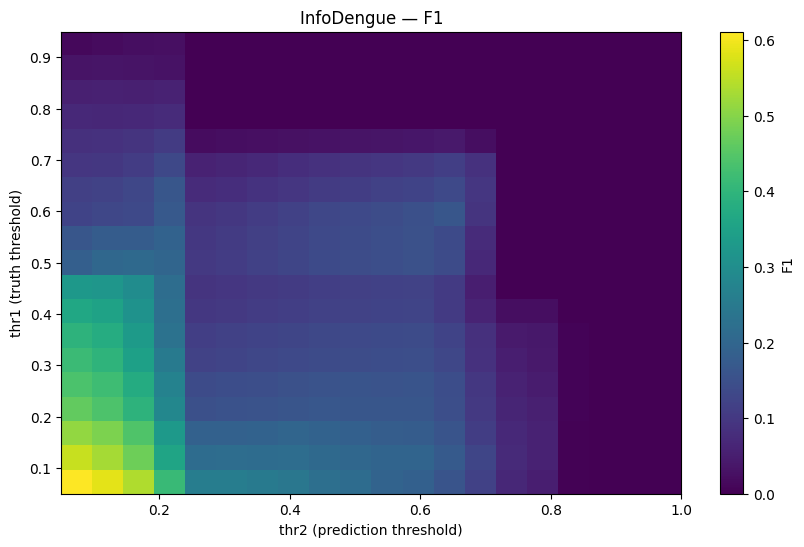

In [ ]:
summ_id, roc_id, f1_id = roc_f1_eval(p_dx, phat_id, data_cols)
f1_heatmap_from_stores(f1_id, title_prefix="InfoDengue")

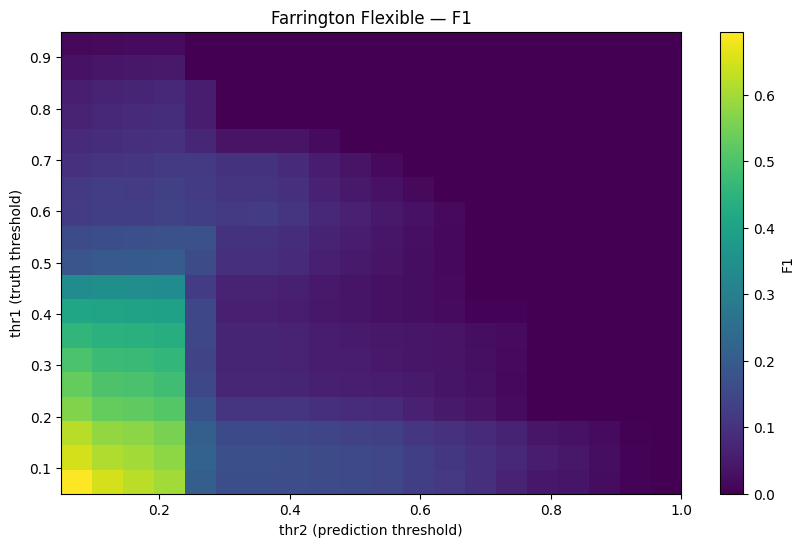

In [ ]:
summ_ff, roc_ff, f1_ff = roc_f1_eval(p_dx, phat_ff, data_cols)
f1_heatmap_from_stores(f1_ff, title_prefix="Farrington Flexible")

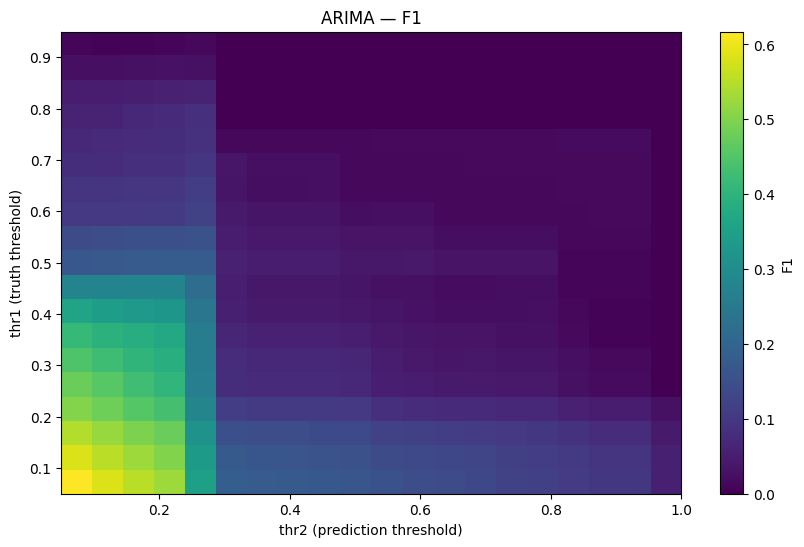

In [ ]:
summ_ar, roc_ar, f1_ar = roc_f1_eval(p_dx, phat_arima, data_cols)
f1_heatmap_from_stores(f1_ar, title_prefix="ARIMA")

In [ ]:
def plot_micro_roc_multi_thr1(p_dx, p_hat, cols,
                             thr1_list=(0.10, 0.20, 0.30),
                             thr2_marks=None,
                             title=None):
    y_score = p_hat[cols].to_numpy().ravel()

    plt.figure(figsize=(7,6))
    plt.plot([0,1],[0,1],"--", linewidth=1)

    for thr1 in thr1_list:
        y_true = (p_dx[cols].to_numpy() >= thr1).astype(int).ravel()
        if np.unique(y_true).size < 2:
            print(f"skip thr1={thr1:.2f} (only one class in y_true)")
            continue

        fpr, tpr, thr2 = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
        plt.plot(fpr, tpr, label=f"thr1={thr1:.2f} | AUC={auc:.3f}")

        if thr2_marks is not None:
            for m in thr2_marks:
                i = int(np.argmin(np.abs(thr2 - m)))
                plt.scatter([fpr[i]], [tpr[i]], s=25)
                plt.text(fpr[i], tpr[i], f" {m:.2f}", fontsize=8, va="bottom")

    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.show()


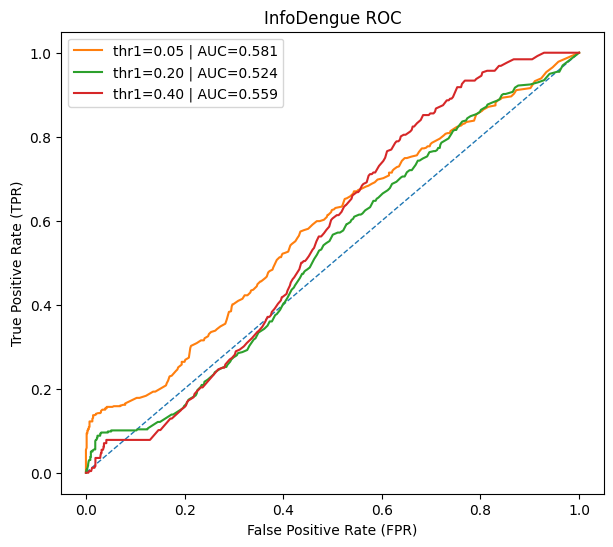

In [ ]:
plot_micro_roc_multi_thr1(p_dx, phat_id, data_cols, thr1_list=(0.05,0.2,0.4), title="InfoDengue ROC")

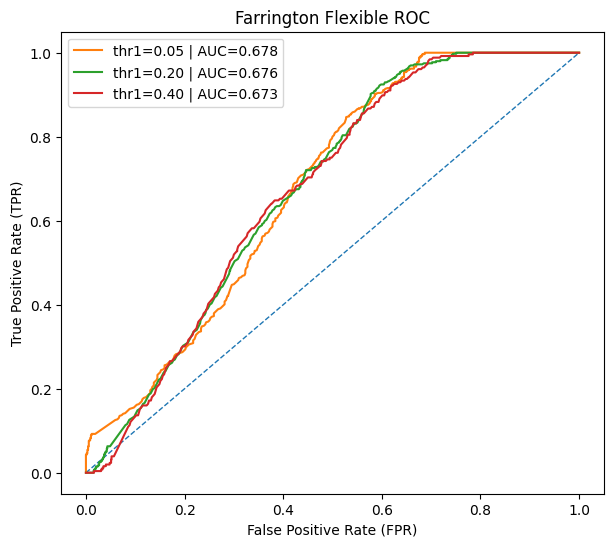

In [ ]:
plot_micro_roc_multi_thr1(p_dx, phat_ff, data_cols, thr1_list=(0.05,0.2,0.4), title="Farrington Flexible ROC")

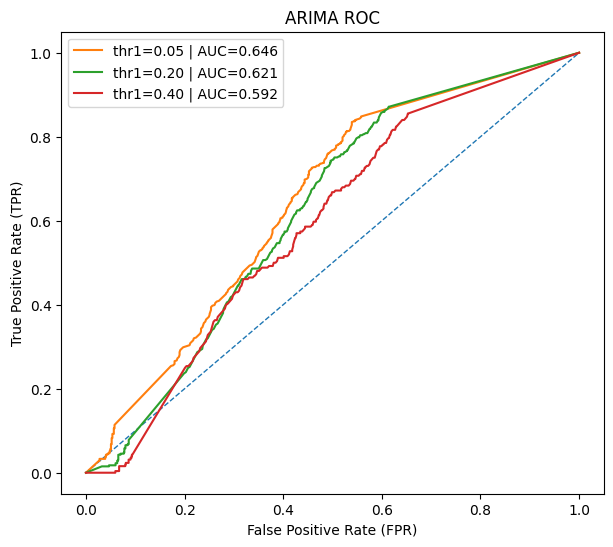

In [ ]:
plot_micro_roc_multi_thr1(p_dx, phat_arima, data_cols, thr1_list=(0.05,0.2,0.4), title="ARIMA ROC")

In [ ]:
def plot_best_f1_and_thr2_vs_thr1(best_df, title=None):
    """
    best_df: output table from roc_f1_eval (or your aggregated table),
             must contain columns: thr1, best_f1, best_thr2
    """
    d = best_df.sort_values("thr1").copy()

    fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    # panel 1: best F1 vs thr1
    ax[0].plot(d["thr1"], d["best_f1"], marker="o")
    ax[0].set_xlabel("thr1 (truth threshold)")
    ax[0].set_ylabel("best F1")
    ax[0].set_title("Best F1 vs thr1")

    # panel 2: best thr2 vs thr1
    ax[1].plot(d["thr1"], d["best_thr2"], marker="o")
    ax[1].set_xlabel("thr1 (truth threshold)")
    ax[1].set_ylabel("best thr2 (prediction threshold)")
    ax[1].set_title("Best thr2 vs thr1")

    if title is not None:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()


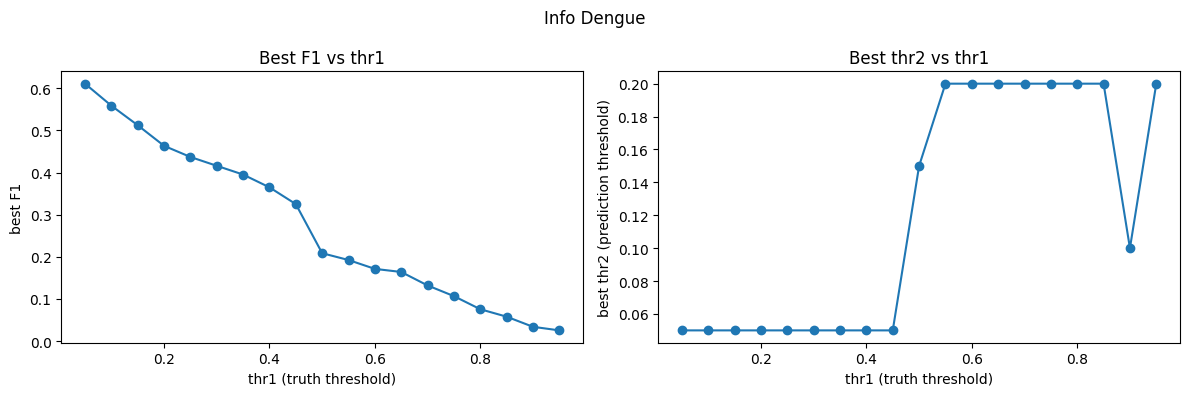

In [ ]:
plot_best_f1_and_thr2_vs_thr1(summ_id, title="Info Dengue")


In [ ]:
p_dx

,1V_E.1,2II_F.1.1.2,3III_B.3.2,other,endemic,non_case,date,states
0,0.0,0.885137,0.000000,0.000000,0.114863,0,2022-02-27,MG
1,0.0,0.928801,0.000000,0.000000,0.071199,0,2022-04-10,MG
2,0.0,0.923175,0.000000,0.000000,0.076825,0,2022-04-17,MG
3,0.0,0.910968,0.000000,0.000000,0.089032,0,2022-04-24,MG
4,0.0,0.912921,0.000000,0.000000,0.087079,0,2022-05-01,MG
...,...,...,...,...,...,...,...,...
211,0.0,0.353863,0.000000,0.353863,0.292274,0,2025-07-06,SP
212,0.0,0.315746,0.000000,0.315746,0.368507,0,2025-07-13,SP
213,0.0,0.205761,0.102881,0.308642,0.382717,0,2025-07-20,SP
214,0.0,0.309231,0.000000,0.309231,0.381537,0,2025-07-27,SP


In [ ]:
phat_ff

,date,endemic,non_case,states,1V_E.1,2II_F.1.1.2,3III_B.3.2,other
0,2022-02-27,0.673635,0.0,MG,0.081591,0.081591,0.081591,0.081591
1,2022-04-10,0.008454,0.0,MG,0.247886,0.247886,0.247886,0.247886
2,2022-04-17,0.004080,0.0,MG,0.248980,0.248980,0.248980,0.248980
3,2022-04-24,0.000913,0.0,MG,0.249772,0.249772,0.249772,0.249772
4,2022-05-01,0.000388,0.0,MG,0.249903,0.249903,0.249903,0.249903
...,...,...,...,...,...,...,...,...
211,2025-07-06,0.748415,0.0,SP,0.062896,0.062896,0.062896,0.062896
212,2025-07-13,0.708829,0.0,SP,0.072793,0.072793,0.072793,0.072793
213,2025-07-20,0.753817,0.0,SP,0.061546,0.061546,0.061546,0.061546
214,2025-07-27,0.783674,0.0,SP,0.054081,0.054081,0.054081,0.054081


In [ ]:
def eval_threshold_prf(
    p_true: pd.DataFrame,
    p_pred: pd.DataFrame,
    threshold: float = 0.5,
    key_cols=("date", "states"),
    prob_cols=None,
    make_plot: bool = True,
    plot_metric: str = "f1",   # "precision" | "recall" | "f1"
    top_n: int | None = None,  # if set, plot only top_n by plot_metric
):


    key_cols = list(key_cols)

    # --- decide probability columns ---
    if prob_cols is None:
        prob_cols = [c for c in p_true.columns if c not in key_cols]
    prob_cols = list(prob_cols)

    # --- keep only needed cols and align on keys ---
    true_df = p_true[key_cols + prob_cols].copy()
    pred_df = p_pred[key_cols + prob_cols].copy()

    aligned = true_df.merge(pred_df, on=key_cols, how="inner", suffixes=("_true", "_pred"))
    if aligned.empty:
        raise ValueError("No overlapping rows after merge on key_cols. Check date/states formats.")

    # --- binarize ---
    Y_true = (aligned[[f"{c}_true" for c in prob_cols]].to_numpy(dtype=float) >= threshold).astype(int)
    Y_pred = (aligned[[f"{c}_pred" for c in prob_cols]].to_numpy(dtype=float) >= threshold).astype(int)

    # --- per-class metrics ---
    p_c, r_c, f1_c, supp = precision_recall_fscore_support(
        Y_true, Y_pred, average=None, zero_division=0
    )

    per_class = pd.DataFrame({
        "class": prob_cols,
        "precision": p_c,
        "recall": r_c,
        "f1": f1_c,
        "support": supp,  # count of true positives per class (in multilabel sense)
    }).sort_values(["f1", "support"], ascending=[False, False]).reset_index(drop=True)

    # --- summary metrics ---
    def _avg(avg):
        pr, re, f1, _ = precision_recall_fscore_support(Y_true, Y_pred, average=avg, zero_division=0)
        return pr, re, f1

    micro = _avg("micro")
    macro = _avg("macro")
    weighted = _avg("weighted")

    summary = pd.DataFrame({
        "avg": ["micro", "macro", "weighted"],
        "precision": [micro[0], macro[0], weighted[0]],
        "recall":    [micro[1], macro[1], weighted[1]],
        "f1":        [micro[2], macro[2], weighted[2]],
        "threshold": [threshold, threshold, threshold],
        "n_rows":    [len(aligned)] * 3,
    })

    # --- optional plot (per-class bar plot) ---
    if make_plot:
        if plot_metric not in {"precision", "recall", "f1"}:
            raise ValueError("plot_metric must be 'precision', 'recall', or 'f1'.")

        plot_df = per_class.copy()
        if top_n is not None:
            plot_df = plot_df.nlargest(top_n, plot_metric)

        x = np.arange(len(plot_df))
        plt.figure(figsize=(max(10, 0.5 * len(plot_df)), 5))
        plt.bar(x, plot_df[plot_metric].values)
        plt.xticks(x, plot_df["class"].values, rotation=45, ha="right")
        plt.ylim(0, 1.0)
        plt.ylabel(plot_metric)
        plt.title(f"Per-class {plot_metric} @ threshold={threshold} (n={len(aligned)})")
        plt.tight_layout()
        plt.show()

    return summary, per_class, aligned

In [ ]:
summary_df_ff, per_class_df_ff, aligned_df_ff = eval_threshold_prf(p_dx, phat_ff, threshold=0.5, make_plot=False)

NameError: name 'precision_recall_fscore_support' is not defined

In [ ]:
summary_df_ff

In [ ]:
summary_df_aa, per_class_df_aa, aligned_df_aa = eval_threshold_prf(p_dx, phat_arima, threshold=0.5, make_plot=False)

In [ ]:
summary_df_aa

In [ ]:
def _coerce_date(df, date_col="date"):
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col], errors="coerce")
    return out

p_dx2   = _coerce_date(p_dx, "date")
phat_id2 = _coerce_date(phat_id, "date")

summary_df_id, per_class_df_id, aligned_df_id = eval_threshold_prf(
    p_dx2, phat_id2, threshold=0.5, make_plot=False
)

In [ ]:
summary_df_id

In [ ]:
per_class_df_id